In [1]:
import pandas as pd
from utils import read_mtx, read_mtxR
import scipy.stats
from scipy.stats import gaussian_kde

In [156]:
import sys

In [353]:
import pickle
with open('/Share2/home/zhangqf5/yanqiu/scAR_old/split_seq/split-seq-pipeline/INDEX_mm_hg/gene_info.pkl', 'rb') as f:
    gene_info = pickle.load(f)

In [59]:
from RNA_coverage import rpkm
import matplotlib.pyplot as plt
from utils import plot_cor
%matplotlib inline

In [211]:
def fpkm_RNA(indir, sample, genome):
    df=read_mtx(indir+'/DGE_filtered/%s_RNA'%sample)
    counts=bulk_count(df)
    fpkm=rpkm(gene_info,counts)
    fpkm.columns=['fpkm']
    if genome=='hg':
        name_prefix='ENSG'
    elif genome=='mm':
        name_prefix='ENSMUSG'
    index=[]
    for i in range(fpkm.shape[0]):
        if fpkm.index[i].startswith(name_prefix):
            index.append(i)
    fpkm=fpkm.iloc[index, :]
    fpkm.to_csv(indir+'/analysis/'+sample+'.fpkm',sep='\t',header=True, index=True)

In [212]:
def fpkm_RNA2(indir, sample, genome):
    df=read_mtxR(indir+'/DGE_filtered/%s_RNA'%sample)
    counts=bulk_count(df)
    fpkm=rpkm(gene_info,counts)
    fpkm.columns=['fpkm']
    if genome=='hg':
        name_prefix='ENSG'
    elif genome=='mm':
        name_prefix='ENSMUSG'
    index=[]
    for i in range(fpkm.shape[0]):
        if fpkm.index[i].startswith(name_prefix):
            index.append(i)
    fpkm=fpkm.iloc[index, :]
    fpkm.to_csv(indir+'/analysis/'+sample+'.fpkm',sep='\t',header=True, index=True)

In [ ]:
indir='/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191030/ZJS191030_R'
fpkm_RNA(indir, '3T3', 'mm')
fpkm_RNA(indir, 'Hela', 'hg')
fpkm_RNA(indir, 'K562', 'hg')

In [213]:
indir2='/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191025/ZJS191025_NorR/'
fpkm_RNA2(indir2, '3T3', 'mm')
fpkm_RNA2(indir2, 'Hela', 'hg')
fpkm_RNA2(indir2, '293', 'hg')

total/filtered/left: 15637/6/15631


Correlation (0.9542215408152256, 0.0)


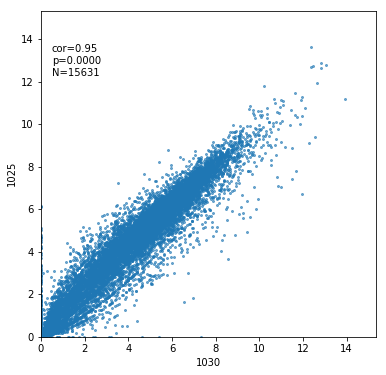

In [214]:
plot_cor_df(indir+'/analysis/Hela.fpkm',indir2+'/analysis/Hela.fpkm','1030','1025')

total/filtered/left: 16673/11/16662


Correlation (0.9610467298324903, 0.0)


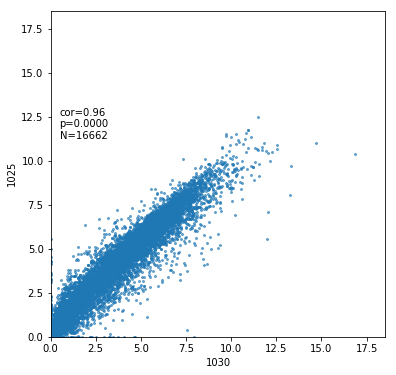

In [215]:
plot_cor_df(indir+'/analysis/3T3.fpkm',indir2+'/analysis/3T3.fpkm','1030','1025')

In [174]:
def bulk_count(df):
    # N_features*N_barcodes
    df['counts']=df.sum(axis=1)
    df=df[['counts']]
    return df

In [207]:
def annotate_gene(genes, gene_anno):
    filtered=[]
    gene_ids=[] 
    for gene in genes:
        try:
            gene_id=gene_anno['name_to_id'][gene]
            if len(gene_id)==1 and (gene_id[0] not in gene_ids):
                filtered.append(gene)
                gene_ids.append(gene_id[0])
        except:
            pass
    return filtered, gene_ids

In [245]:
def is_gene_id(name):
    if name.startswith('ENS') and (len(name.split('.'))==2):
        return True

In [315]:
def plot_cor_df(fpkm1, fpkm2, sample1,sample2, gene_anno, normalize=1000000, how='inner',with_density=False):
    if type(fpkm1)==str:
        fpkm1=pd.read_csv(fpkm1, sep='\s+', header=0, index_col=0)
    if type(fpkm2)==str:
        fpkm2=pd.read_csv(fpkm2, sep='\s+', header=0, index_col=0)
    fpkm1 = fpkm1.loc[~fpkm1.index.duplicated(keep='first')]
    fpkm2 = fpkm2.loc[~fpkm2.index.duplicated(keep='first')]
    if not is_gene_id(fpkm1.index.values[0]):
        filtered, gene_ids=annotate_gene(fpkm1.index.values,gene_anno)
        fpkm1=fpkm1.loc[filtered,:]
        fpkm1.index=gene_ids
    if not is_gene_id(fpkm2.index.values[0]):
        filtered, gene_ids=annotate_gene(fpkm2.index.values,gene_anno)        
        fpkm2=fpkm2.loc[filtered,:]
        fpkm2.index=gene_ids
    fpkm1.index=[x.split('.')[0] for x in fpkm1.index]
    fpkm2.index=[x.split('.')[0] for x in fpkm2.index]
    merged=pd.merge(fpkm1, fpkm2, left_index=True, right_index=True, how=how)
    merged.columns=[sample1,sample2]    
    cor=plot_cor(merged[sample1], merged[sample2],sample1,sample2, normalize=normalize,with_density=with_density)

In [314]:
type('str')==str

True

In [277]:
indir='/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191030_R'
sample='K562'
df=read_mtx(indir+'/DGE_filtered/%s_RNA'%sample)
counts=bulk_count(df)
fpkm=rpkm(gene_info,counts)
pub_file='/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/2011_ENCODE_K562_RNA.rpkm.txt'
pub_df=pd.read_csv(pub_file, sep='\t', header=0, index_col=0)
how='inner'
merged=pd.merge(fpkm, pub_df, left_index=True, right_index=True, how=how)
merged.columns=[sample, 'published']
merged=merged.fillna(0)

In [186]:
def cor_RNA(indir, sample, pub_file, genome, how='outer'):
    df=read_mtx(indir+'/DGE_filtered/%s_RNA'%sample)
    counts=bulk_count(df)
    fpkm=rpkm(gene_info,counts)
    fpkm.index=[x.split('.')[0] for x in fpkm.index]
    if genome=='hg':
        name_prefix='ENSG'
    elif genome=='mm':
        name_prefix='ENSMUSG'
    index=[]
    for i in range(fpkm.shape[0]):
        if fpkm.index[i].startswith(name_prefix):
            index.append(i)
    fpkm=fpkm.iloc[index, :]
    pub_df=pd.read_csv(pub_file, sep='\t', header=0, index_col=0)
    pub_df.index=[x.split('.')[0] for x in pub_df.index]
    merged=pd.merge(fpkm, pub_df, left_index=True, right_index=True, how=how)
    merged.columns=[sample, 'published']
    merged=merged.fillna(0)
    cor=plot_cor(merged[sample], merged['published'],sample,'published', normalize=1000000)

In [434]:
indir="/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191030/ZJS191030_R/"

total/filtered/left: 20553/8/20545


Correlation (0.7814372711420551, 0.0)


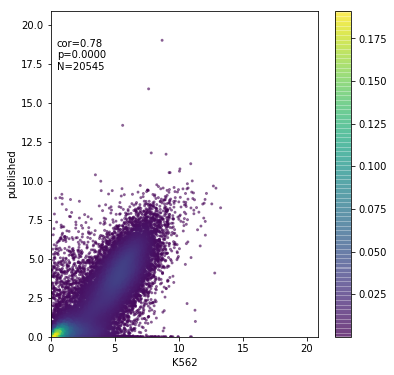

In [435]:
cor_RNA(indir, 'K562','/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/2011_ENCODE_K562_RNA.rpkm.txt','hg','inner')

Correlation (0.4963045415975937, 0.0)


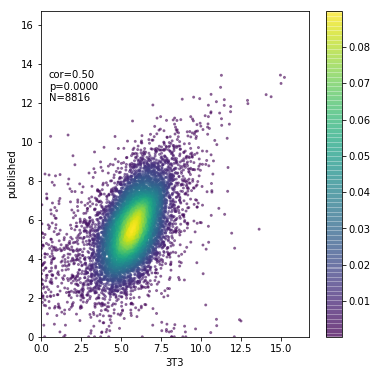

In [436]:
cor_RNA(indir, '3T3','/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/2013_MC_3T3_RNA.rpkm.txt','mm', 'inner')

In [319]:
pub_Hela=pd.read_csv('/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/2014_NC_Hela_RNA.count.txt', sep='\t', index_col=0, header=0)
pub_Hela['mean_count']=pub_Hela.apply(lambda x: np.mean(x), axis=1)
gene_info2={'gene_starts':{},'gene_ends':{}}
for gene in gene_info['gene_starts'].keys():
    gene_info2['gene_starts'][gene.split('.')[0]]=gene_info['gene_starts'][gene]
    gene_info2['gene_ends'][gene.split('.')[0]]=gene_info['gene_ends'][gene]
Hela_fpkm=rpkm(gene_info2,pub_Hela[['mean_count']] )
Hela_fpkm.to_csv('/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/2014_NC_Hela_RNA.rpkm.txt',sep='\t')

total/filtered/left: 17076/10/17066


Correlation (0.6397955763504011, 0.0)


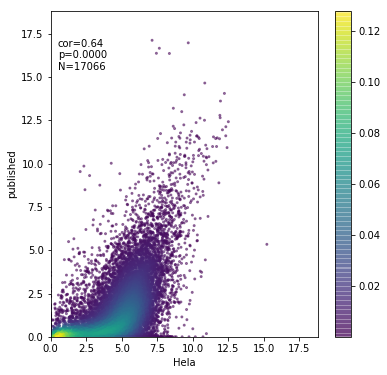

In [437]:
cor_RNA(indir, 'Hela','/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/2014_NC_Hela_RNA.rpkm.txt','hg','inner')

In [327]:
def cor_RNA_old(indir, sample, pub_file, genome):
    df=read_mtxR(indir+'/DGE_filtered/%s_RNA'%sample)
    counts=bulk_count(df)
    fpkm=rpkm(gene_info,counts)
    fpkm.index=[x.split('.')[0] for x in fpkm.index]
    if genome=='hg':
        name_prefix='ENSG'
    elif genome=='mm':
        name_prefix='ENSMUSG'
    index=[]
    for i in range(fpkm.shape[0]):
        if fpkm.index[i].startswith(name_prefix):
            index.append(i)
    fpkm=fpkm.iloc[index, :]
    pub_df=pd.read_csv(pub_file, sep='\t', header=0, index_col=0)
    pub_df.index=[x.split('.')[0] for x in pub_df.index]
    how='outer'
    merged=pd.merge(fpkm, pub_df, left_index=True, right_index=True, how=how)
    merged.columns=[sample, 'published']
    merged=merged.fillna(0)
    cor=plot_cor(merged[sample], merged['published'],sample,'published', normalize=1000000)

Correlation (0.6458895999212222, 0.0)


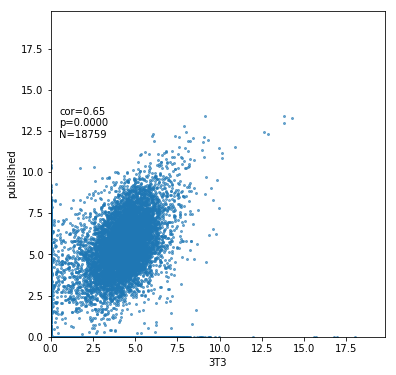

In [415]:
cor_RNA_old('/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191025/ZJS191025_NorR/', '3T3',
            '/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/2013_MC_3T3_RNA.rpkm.txt','mm')

In [333]:
import numpy as npz

In [338]:
Hela_DNA=pd.read_csv('/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191030_A/bam_cor/Hela.counts',header=0, sep='\t', index_col=None)

total/filtered/left: 291652/23/291629


Correlation (0.7613835121729167, 0.0)


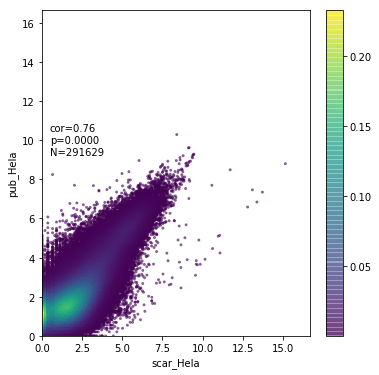

(0.7613835121729167, 0.0)

In [438]:
plot_cor(Hela_DNA.iloc[:,-1],Hela_DNA.iloc[:,-2],'scar_Hela','pub_Hela', method='pearson',normalize=2000000,save=None)

total/filtered/left: 292740/20/292720


Correlation (0.7723827316790597, 0.0)


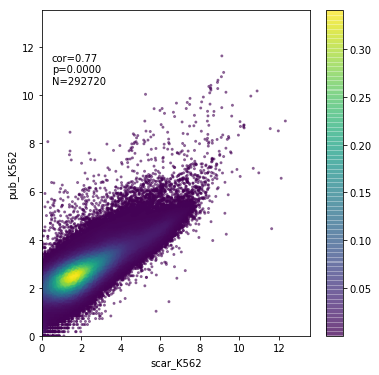

(0.7723827316790597, 0.0)

In [439]:
#K562_DNA=pd.read_csv('/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191030_A/bam_cor/K562.counts',header=0, sep='\t', index_col=None)
plot_cor(K562_DNA.iloc[:,-1],K562_DNA.iloc[:,-2],'scar_K562','pub_K562', method='pearson',normalize=2000000,save=None)

total/filtered/left: 257638/19/257619


Correlation (0.6530407194640815, 0.0)


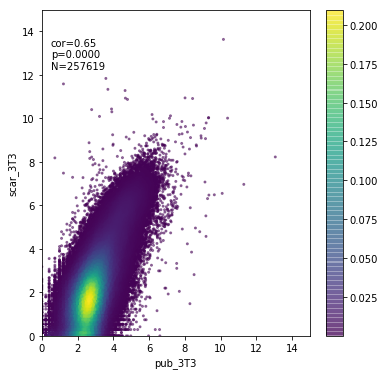

(0.6530407194640815, 0.0)

In [440]:
plot_cor(m3T3_DNA.iloc[:,-2],m3T3_DNA.iloc[:,-1],'pub_3T3','scar_3T3', method='pearson',normalize=2000000,save=None)

In [ ]:
####ZJS191116

total/filtered/left: 17109/6/17103


Correlation (0.7814539419065945, 0.0)


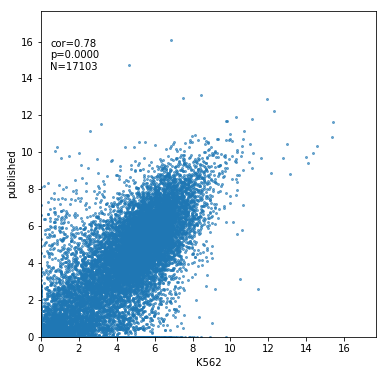

In [418]:
cor_RNA('/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191116/oR', 'K562','/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/2011_ENCODE_K562_RNA.rpkm.txt','hg','inner')

total/filtered/left: 14081/4/14077


Correlation (0.6958780405757553, 0.0)


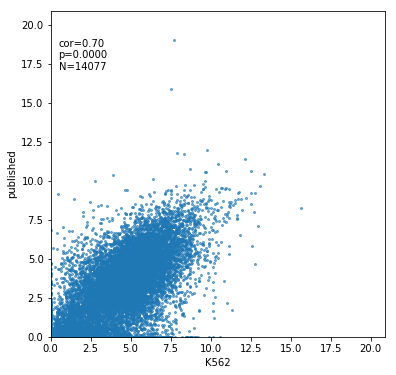

In [420]:
cor_RNA('/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191116/coR', 'K562','/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/2011_ENCODE_K562_RNA.rpkm.txt','hg','inner')

total/filtered/left: 18131/15/18116


Correlation (0.5958039561137303, 0.0)


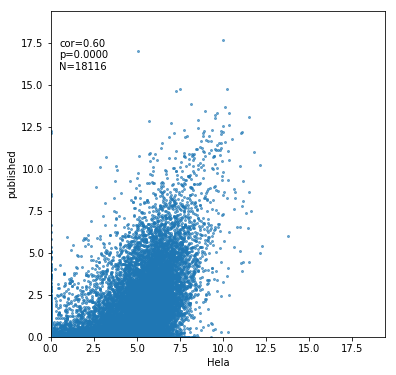

In [421]:
cor_RNA('/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191116/oR', 'Hela','/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/2014_NC_Hela_RNA.rpkm.txt','hg','inner')

total/filtered/left: 18131/15/18116


Correlation (0.5958039561137303, 0.0)


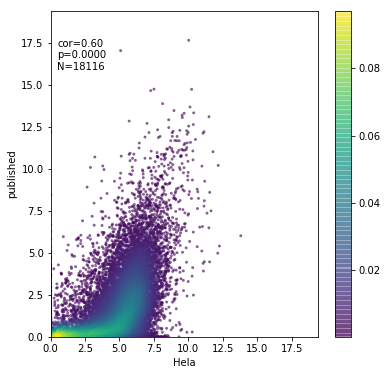

In [427]:
cor_RNA('/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191116/oR', 'Hela','/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/2014_NC_Hela_RNA.rpkm.txt','hg','inner')

Correlation (0.5263533600226784, 0.0)


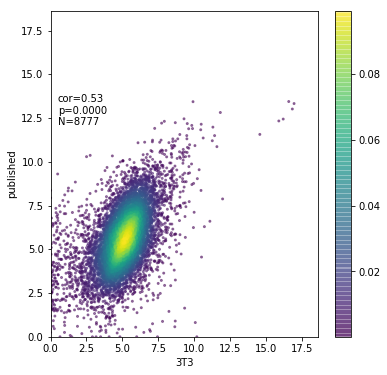

In [424]:
cor_RNA('/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191116/oR', '3T3','/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/2013_MC_3T3_RNA.rpkm.txt','mm', 'inner')

# split-seq matrix

In [3]:
import scipy.io
mat = scipy.io.loadmat('/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/GSM3017263_same_day_cells_nuclei_300_UBCs')
mat2 = scipy.io.loadmat('/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/GSM3017265_frozen_preserved_cells_nuclei_200_UBCs.mat')
mat3 = scipy.io.loadmat('/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/GSM3017262_same_day_cells_nuclei_3000_UBCs.mat')
mat4 = scipy.io.loadmat('/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/GSM3017264_frozen_preserved_cells_nuclei_1000_UBCs.mat')

In [11]:
mat3

{'DGE': <3246x75187 sparse matrix of type '<class 'numpy.float64'>'
 	with 14098285 stored elements in Compressed Sparse Column format>,
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Feb 18 17:58:47 2018',
 '__version__': '1.0',
 'barcodes': array(['AAACATCGAACTCACC_28', 'AAACATCGAATGTTGC_20',
        'AAACATCGACACAGAA_10', ..., 'TTCACGCATCCGTCTA_41',
        'TTCACGCATCTTCACA_18', 'TTCACGCATGGTGGTA_14'], dtype='<U19'),
 'genes': array(['ERBB4_INTRONIC_HUMAN                 ',
        'SPRED1_INTRONIC_HUMAN                ',
        'IPO7_HUMAN                           ', ...,
        'Gm17233_MOUSE                        ',
        'Gpr128_MOUSE                         ',
        'Gjc2_MOUSE                           '], dtype='<U37'),
 'sample_type': array(['nucleus', 'cell   ', 'cell   ', ..., 'nucleus', 'cell   ',
        'cell   '], dtype='<U7')}

In [20]:
tmp=mat['DGE'].astype('int').T

In [44]:
from scipy.io import mmwrite
import os
def write_mtx(matrix, barcodes, features, path):
    if not os.path.exists(path):
        os.makedirs(path)
    mmwrite(path+'/count.mtx', matrix.astype('int'), field='integer')
    np.savetxt(path+'/barcodes.txt',barcodes,fmt="%s")
    np.savetxt(path+'/genes.txt',features,fmt="%s")

In [27]:
write_mtx(mat['DGE'].T, mat['barcodes'], mat['genes'], 
          '/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/fresh_300')
write_mtx(mat2['DGE'].T, mat2['barcodes'], mat2['genes'], 
          '/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/frozen_200')
write_mtx(mat3['DGE'].T, mat3['barcodes'], mat3['genes'], 
          '/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/fresh_3000')
write_mtx(mat4['DGE'].T, mat4['barcodes'], mat4['genes'], 
          '/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/frozen_1000')

In [33]:
np.savetxt('/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/fresh_300/sample_type.txt', 
           mat['sample_type'], fmt='%s')
np.savetxt('/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/frozen_200//sample_type.txt', 
           mat2['sample_type'], fmt='%s')
np.savetxt('/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/fresh_3000//sample_type.txt', 
           mat3['sample_type'], fmt='%s')
np.savetxt('/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/frozen_1000//sample_type.txt', 
           mat4['sample_type'], fmt='%s')

In [39]:
df = pd.DataFrame(mat3['DGE'].todense().T,mat3['genes'], mat3['barcodes'])

In [35]:
np.unique(mat3['sample_type'])

array(['cell   ', 'nucleus'], dtype='<U7')

In [40]:
idx = mat3['sample_type']=='cell   '
df_cell=df.iloc[:,idx]

In [87]:
def filter_cell(df, num=1):
    peak_num=df[df>0].count(axis=0)
    filtered=df.iloc[:,(peak_num>=num).values]
    return filtered
def filter_feature(df, num=1):
    cell_num=df[df>0].count(axis=1)
    filtered=df.iloc[(cell_num>=num).values,:]
    return filtered

In [42]:
cell_num=df_cell[df_cell>0].count(axis=1)
peak_num=df_cell[df_cell>0].count(axis=0)

In [54]:
filtered=df_cell.iloc[(cell_num>0).values,:]

In [55]:
filtered.shape

(69589, 1758)

In [112]:
from utils import cluster_tsne_pca

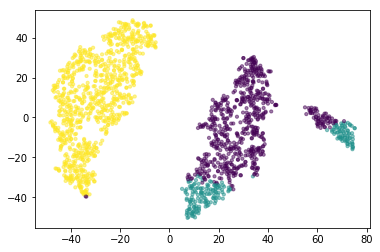

In [74]:
X,X2,y=cluster_tsne_pca(filtered.T,3)

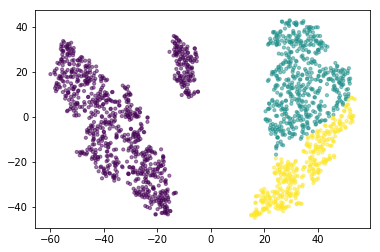

In [113]:
X,X2,y=cluster_tsne_pca(filtered.T, 3, method='gmm')

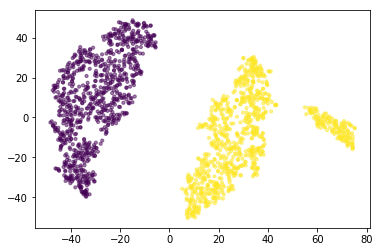

In [81]:
y_pred = KMeans(n_clusters=2, random_state=2).fit_predict(X2)
plt.scatter(X2[:,0],X2[:,1],alpha=0.5,s=10,c=y_pred)

In [82]:
print(sum(y_pred==0), sum(y_pred==1))

888 870


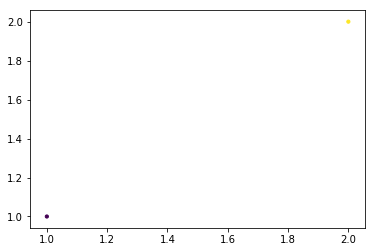

In [115]:
plt.scatter([1,2],[1,2],s=10,c=[0,1])

In [86]:
group1=filtered.iloc[:,y_pred==0]
group1=filter_feature(group1, group1.shape[1]*0.1)

In [98]:
group2=filtered.iloc[:,y_pred==1]
group2=filter_feature(group2, group2.shape[1]*0.1)

In [99]:
genes=group2.index
h=0
m=0
for g in genes:
    if g.strip().split('_')[-1]=='HUMAN':
        h+=1
    else:
        m+=1
print(h,m)

14215 12


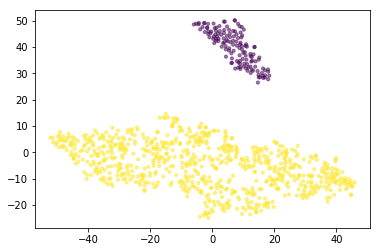

In [116]:
XX,XX2,yy=cluster_tsne_pca(group2.T, 2, method='gmm')

In [117]:
group2_1=group2.iloc[:,yy==0]
group2_2=group2.iloc[:,yy==1]

In [120]:
print(df_cell.shape)

(75187, 1758)


In [122]:
c_3T3=group1.columns
c_HEK=group2_1.columns
c_Hela=group2_2.columns
len(c_3T3)+len(c_HEK)+len(c_Hela)

1758

In [164]:
print(group1.shape, group2_1.shape, group2_2.shape)

(11368, 888) (14227, 138) (14227, 732)


In [123]:
cell_type=[]
for cell in df_cell.columns:
    if cell in c_3T3:
        cell_type.append('3T3')
    elif cell in c_HEK:
        cell_type.append('HEK293')
    elif cell in c_Hela:
        cell_type.append('Hela')
np.savetxt('/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/fresh_3000/cell_type.txt', 
           cell_type, fmt='%s')

In [226]:
list(gene_anno_mm['name_to_id'].keys())[-5:]

['ENSMUSG00000064371',
 'ENSMUSG00000064371.1',
 'mt-Tp',
 'ENSMUSG00000064372',
 'ENSMUSG00000064372.1']

In [129]:
print(list(gene_id_to_name.keys())[:5], list(gene_id_to_name.values())[:5])

['ENSG00000223972.5', 'ENSG00000227232.5', 'ENSG00000278267.1', 'ENSG00000243485.5', 'ENSG00000284332.1'] ['DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'MIR1302-2']


In [130]:
print(list(gene_info_mm['gene_id_to_name'].keys())[:5], list(gene_info_mm['gene_id_to_name'].values())[:5])

['ENSMUSG00000102693.1', 'ENSMUSG00000064842.1', 'ENSMUSG00000051951.5', 'ENSMUSG00000102851.1', 'ENSMUSG00000103377.1'] ['4933401J01Rik', 'Gm26206', 'Xkr4', 'Gm18956', 'Gm37180']


In [134]:
name_to_id_len=[len(el) for el in gene_anno_hg['name_to_id'].values()]

In [ ]:
human_genes=[]
mouse_genes=[]
genes=df_cell.index
for g in genes:
    if g.strip().split('_')[-1]=='HUMAN':
        human_genes.append(g)
    elif g.strip().split('_')[-1]=='MOUSE':
        mouse_genes.append(g)

In [160]:
from RNA_coverage import rpkm

def clean_matrix(df, geneset, gene_anno):
    overlap=list(set(df.index)&set(geneset))
    df=df.loc[overlap,:]
    filtered=[]
    new_index=[]
    
    for gene in df.index:
        try:
            gene_id=gene_anno['name_to_id'][gene.split('_')[0]]
            if len(gene_id)==1 and (gene_id[0] not in new_index):
                filtered.append(gene)
                new_index.append(gene_id[0])
        except:
            pass
    df=df.loc[filtered,:]
    df.index=new_index
    return df
        

In [161]:
df_3T3=clean_matrix(group1, mouse_genes, gene_anno_mm)

In [165]:
df_HEC=clean_matrix(group2_1, human_genes, gene_anno_hg)

In [166]:
df_Hela=clean_matrix(group2_2, human_genes, gene_anno_hg)

In [167]:
print(df_3T3.shape, df_HEC.shape, df_Hela.shape)

(7034, 888) (8405, 138) (8405, 732)


In [168]:
from utils import write_mtx

In [172]:
write_mtx(df_3T3.astype('int'), '/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/fresh_3T3')
write_mtx(df_HEC.astype('int'), '/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/fresh_HEK293')
write_mtx(df_Hela.astype('int'), '/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/fresh_Hela')

In [176]:
split_3T3_counts=bulk_count(df_3T3)
split_3T3_fpkm=rpkm(gene_info_mm,split_3T3_counts)
split_3T3_fpkm.columns=['fpkm']
split_3T3_fpkm.to_csv('/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/fresh_3T3.fpkm',sep='\t',header=True, index=True)

In [201]:
split_Hela_counts=bulk_count(df_Hela)
split_Hela_fpkm=rpkm(gene_info_hg,split_Hela_counts)
split_Hela_fpkm.columns=['fpkm']
split_Hela_fpkm.to_csv('/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/fresh_Hela.fpkm',sep='\t',header=True, index=True)

total/filtered/left: 6940/7/6933


Correlation (0.6471130037294358, 0.0)


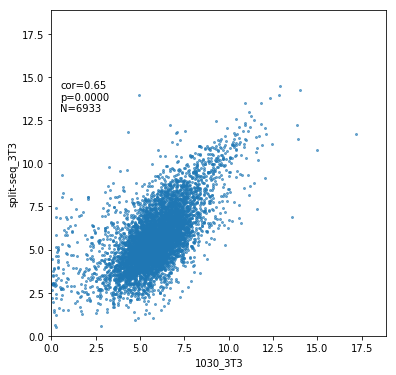

total/filtered/left: 8019/4/8015


Correlation (0.60058281408473, 0.0)


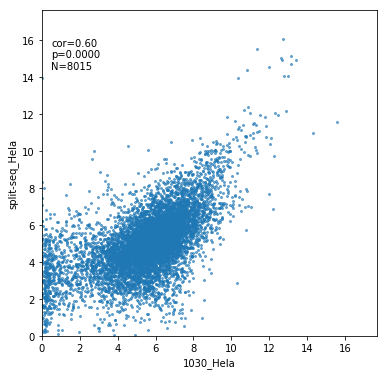

In [280]:
plot_cor_df('/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191030/ZJS191030_R/analysis/3T3.fpkm',
            '/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/fresh_3T3.fpkm',
            '1030_3T3','split-seq_3T3', gene_anno_mm)
plot_cor_df('/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191030/ZJS191030_R/analysis/Hela.fpkm',
            '/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/fresh_Hela.fpkm',
            '1030_Hela','split-seq_Hela', gene_anno_hg)

Correlation (0.5570278785465163, 0.0)


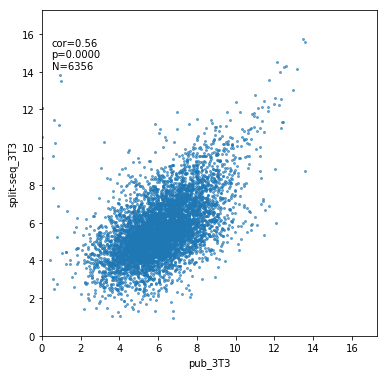

total/filtered/left: 8398/16/8382


Correlation (0.6839194216491647, 0.0)


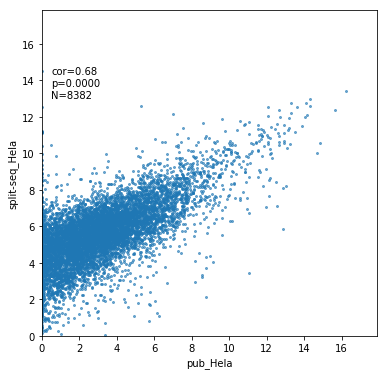

In [275]:
plot_cor_df('/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/2013_MC_3T3_RNA.rpkm.txt',
            '/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/fresh_3T3.fpkm',
            'pub_3T3','split-seq_3T3', gene_anno_mm)
plot_cor_df('/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/2014_NC_Hela_RNA.rpkm.txt',
            '/Share2/home/zhangqf5/yanqiu/scAR/datasets/split-seq/fresh_Hela.fpkm',
            'pub_Hela','split-seq_Hela', gene_anno_hg)

# new ENCODE dataset

In [317]:
import os
def split_attributes(s):
    """ Returns a dictionary from string of attributes in a GTF/GFF file
    """
    att_list = s[:-1].split('; ')
    att_keys = [a.split(' ')[0] for a in att_list]
    att_values = [' '.join(a.split(' ')[1:]) for a in att_list]
    return dict(zip(att_keys,att_values))
def get_attribute(s,att):
    att_value = ''
    try:
        att_value = split_attributes(s)[att].strip('"')
    except:
        att_value = ''
    return att_value
def parse_gtf(gtf, attributes):
    names = ['Chromosome','Source','Feature','Start','End','Score','Strand','Frame','Attributes']
    if type(gtf)==str:
        gtf=pd.read_csv(gtf,sep='\t',header=None,index_col=None, comment='#')
        gtf.columns=names
    gtf_attr=pd.DataFrame()
    for attr in attributes:
        if attr in names:
            gtf_attr[attr]=gtf[attr]
        else:
            try:
                gtf_attr[attr]=gtf['Attributes'].apply(lambda s: get_attribute(s,attr))
            except:
                print('ValueError: Attribute Name not valid!')
    return gtf_attr

In [287]:
# Hela
gene_quan_f='/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/raw/ENCODE/Hela/GSE86661_ENCFF000FOD_gene_quantifications_hg19.gtf.gz'
names = ['Chromosome','Source','Feature','Start','End','Score','Strand','Frame','Attributes']
gtf=pd.read_csv(gene_quan_f,sep='\t',header=None,index_col=None, comment='#')
gtf.columns=names


In [294]:
Hela_rpkm=parse_gtf(gtf, ['gene_id','RPKM1','RPKM2'])
Hela_rpkm.index=Hela_rpkm['gene_id']
Hela_rpkm=Hela_rpkm[['RPKM1','RPKM2']]
Hela_rpkm.fillna(0)
Hela_rpkm=Hela_rpkm.astype('float')
Hela_rpkm['rpkm']=Hela_rpkm.apply(lambda x: (x['RPKM1']+x['RPKM2'])*0.5,axis=1)
Hela_rpkm=Hela_rpkm['rpkm']

total/filtered/left: 15317/4/15313


Correlation (0.6932111049157512, 0.0)


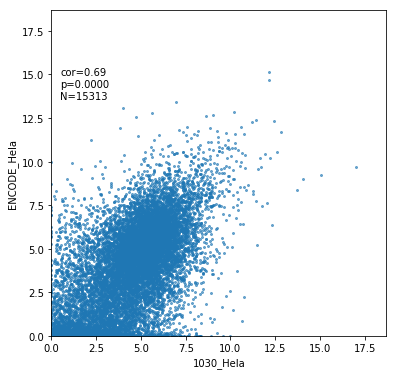

In [320]:
plot_cor_df('/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191030/ZJS191030_R/analysis/Hela.fpkm',
            Hela_rpkm,
            '1030_Hela','ENCODE_Hela', gene_anno_hg)

In [321]:
Hela_rpkm.to_csv('/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/ENCODE_Hela.txt', sep='\t',index=True, header=True)

total/filtered/left: 23251/98/23153


Correlation (0.5098127687332129, 0.0)


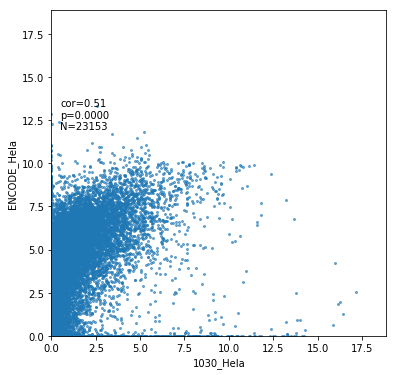

In [323]:
plot_cor_df('/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/2014_NC_Hela_RNA.rpkm.txt',
            Hela_rpkm,
            '1030_Hela','ENCODE_Hela', gene_anno_hg)

In [327]:
# 3T3
mm9='/150T/zhangqf/GenomeAnnotation/Gencode/mm9.gtf'
names = ['Chromosome','Source','Feature','Start','End','Score','Strand','Frame','Attributes']
mm9_df=parse_gtf(mm9, ['Chromosome','Feature','Start','End','gene_id'])

In [329]:
mm9_df=mm9_df[mm9_df['Feature']=='gene']
mm9_df['coor']=mm9_df.apply(lambda x: x['Chromosome']+':'+str(x['Start'])+'-'+str(x['End']),axis=1)
mm9_df.index=mm9_df['coor']

In [333]:
coor_dict=mm9_df['gene_id'].to_dict()

In [372]:

count_3T3=pd.read_csv('/Share2/home/zhangqf5/yanqiu/scAR/public/RNA/raw/ENCODE/3T3/3T3.counts',sep='\t',header=None, index_col=None,comment='#')
count_3T3.columns=['Chromosome','Start','End','count1','count2']
count_3T3['coor']=count_3T3.apply(lambda x: x['Chromosome']+':'+str(x['Start'])+'-'+str(x['End']),axis=1)
count_3T3.index=count_3T3['coor']

In [373]:
count_3T3=count_3T3[['count1','count2']]
count_3T3=count_3T3.fillna(0)
count_3T3=count_3T3.astype('float')
count_3T3['count']=(count_3T3['count1']+count_3T3['count2'])*0.5

In [365]:
def rpkm(genecounts): # index is gene coordinates
    # genecounts: n_features*n_samples
    gene_len={}
    for gene in genecounts.index:
        gene_len[gene]=int(gene.split(':')[1].split('-')[1])-int(gene.split(':')[1].split('-')[0])+1 
    genelen=np.array([gene_len[gene] for gene in genecounts.index])
    fpkm=pd.DataFrame()
    for bc in genecounts.columns:
        fpkm[bc]=genecounts[bc]/sum(genecounts[bc])/genelen*10**9
    return fpkm

In [375]:
rpkm_3T3=rpkm(count_3T3[['count']])

In [380]:
new_index=[coor_dict[el].split('.')[0] for el in count_3T3.index]
rpkm_3T3.index=new_index

In [381]:
rpkm_3T3.columns=['rpkm']

total/filtered/left: 16241/11/16230


Correlation (0.43694324677788954, 0.0)


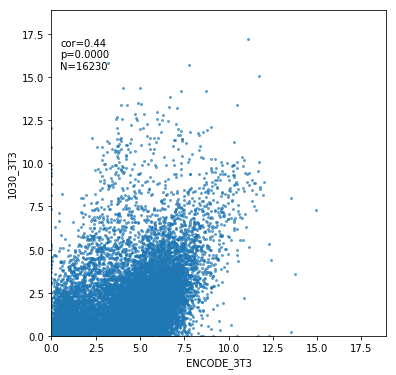

In [382]:
plot_cor_df('/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS191030/ZJS191030_R/analysis/3T3.fpkm',
            rpkm_3T3,
            'ENCODE_3T3','1030_3T3', gene_anno_mm)